# Atomic Simulation Environment (ASE) 

## Atomization energy

The following script will calculate the atomization energy of a nitrogen molecule:

In [ ]:
from ase import Atoms
from ase.calculators.emt import EMT 
'''
EMT potential is included in the ASE package in 
order to have a simple calculator that can be used for 
quick demonstrations and tests.
'''

atom = Atoms('N') #choosing the atom as nitrogen
atom.calc=EMT() #EMT calculator is assigned to the atom. This allows ASE to calculate the potential energy of the atom using the EMT potential.
e_atom = atom.get_potential_energy() # Calculates the potential energy of the single nitrogen atom.

d = 1.1 # bond length
molecule= Atoms('2N', [(0., 0., 0.),(0., 0., d)]) #creating a molecule of N2 
molecule.calc = EMT()
e_molecule = molecule.get_potential_energy()

e_atomization = e_molecule - 2 * e_atom #energy required to break the molecule into individual atoms

# print the energies
print('Nitrogen atom energy: %6.2f eV' %e_atom) 
print('Nitrogen molecule energy: %5.2f eV' %e_molecule) 
print('Atomization energy: %6.2f eV' %e_atomization) 



0.44034357303561467
Nitrogen atom energy:   5.10 eV
Nitrogen molecule energy:  0.44 eV
Atomization energy:  -9.76 eV


**Key takeaways:**

- Atoms Object: Represents a physical system (atoms, molecules, etc.).
- Calculator: Assigns a method to compute properties like potential energy.
- Energy Calculations: Demonstrates how to compute molecular and atomic energies.
- Geometry Definition: Specifies atomic positions and distances in molecules.

---

**Mistakes Made:**

- get_potential_energy(): A method of the ASE Atoms object that returns the total potential energy of the atomic or molecular system as a single scalar value (in electron volts, eV).
- get_potential_energies(): A method that returns a list of potential energies for each atom in the system. This is not typically used to get the total energy of a system, which is what you need for calculating atomization energy.



## Equation of state (EOS)

First, do a bulk calculation for different lattice constants:

100.14189241975804 GPa


<Axes: title={'center': 'sj: E: -0.000 eV, V: 16.781 Å$^3$, B: 100.142 GPa'}, xlabel='volume [Å$^3$]', ylabel='energy [eV]'>

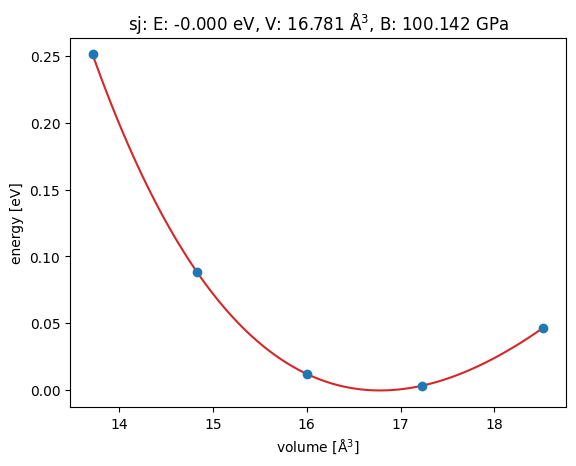

In [ ]:
import numpy as np

from ase import Atoms
from ase.calculators.emt import EMT
from ase.io.trajectory import Trajectory #records the system's atomic configurations.

a= 4.0 # approximate lattice constant
b =a/2 #helper value used to define the unit cell

#Create an atomic system with one silver (Ag) atom
#Defines a cubic unit cell with the silver atom at the origin
#pbc=1: Enables periodic boundary conditions in all three directions
#Assigns the EMT calculator to compute the potential energy
ag = Atoms('Ag',
           cell= [(0,b,b),(b,0,b),(b,b,0)],
           pbc=1,
           calculator=EMT()) 

cell = ag.get_cell() #Stores the initial lattice vectors (unit cell) in the variable cell
traj = Trajectory('Ag.Traj','w') #Creates a trajectory file (Ag.traj) in write mode ('w') to store the atomic configurations

for x in np.linspace(0.95,1.05,5): #scaling factors will be used to stretch and compress the unit cell
    ag.set_cell(cell * x, scale_atoms=True) #Adjusts the atomic positions proportionally to maintain the geometry within the scaled unit cell.
    ag.get_potential_energy()
    traj.write(ag) 

from ase.eos import EquationOfState #utility to fit volumes and energies to an EOS and extract parameters like equilibrium volume, energy, and bulk modulus
from ase.io import read #Used to read atomic configurations from trajectory files or other formats
from ase.units import kJ

configs = read('Ag.traj@0:5') #Read the 5 (0 to 4) configurations
volumes = [ag.get_volume() for ag in configs] #Calculate the volume of each configuration
energies = [ag.get_potential_energy() for ag in configs] #Calculate the energy of each configuration
eos = EquationOfState(volumes, energies) #will fit the data to an analytical EOS model (default is the Birch-Murnaghan EOS)

v0,e0,B = eos.fit()
print(B/kJ * 1.0e24, 'GPa')
eos.plot('Ag-eos.png')

**Key Takeaways:**

- Simulates Scaling Effects: The code explores how the potential energy of a silver atom changes as the lattice is scaled from 95% to 105% of its original size.
- Saves Atomic Configurations: The trajectory file (Ag.traj) stores the atomic configurations for each scaling factor. This file can be used later for visualization or further analysis using ASE tools.
- Trajectory File: Stores atomic configurations for different states of the system.
- Equation of State: Describes the relationship between energy and volume in a material.
- Bulk Modulus: A measure of the material's resistance to compression, derived from the EOS fit.
- Visualization: Saves a plot for further analysis.

## Finding lattice constants using EOS and the stress tensor

In [ ]:
import numpy as np

from ase.build import bulk #utility to construct bulk crystal structures for common materials
from ase.calculators.emt import EMT
from ase.io import Trajectory, read

a0 = 3.52 / np.sqrt(2) #often used in face-centered cubic (FCC) systems where the lattice constant relates to the atomic arrangement
c0 = np.sqrt(8/3.0) * a0 #used to describe the cell dimensions in a non-cubic system such as hexagonal close-packed

traj = Trajectory('Ni.traj', 'w')

eps =0.01 #Used to slightly vary the lattice parameters and explore their effect on the crystal’s potential energy
for a in a0*np.linspace(1-eps,1+eps,3):
    for c in c0*np.linspace(1-eps,1+eps,3):
        ni=bulk('Ni', 'hcp', a=a, c=c) #Specifies a hexagonal close-packed structure
        ni.calc =EMT()
        ni.get_potential_energy()
        traj.write(ni)
        
configs = read('Ni.traj@:') #all entries in the trajectory file should be read
energies = [config.get_potential_energy() for config in configs]
a= np.array([config.cell[0,0] for config in configs]) #Accesses the lattice vector component in the x-direction from the unit cell matrix
c= np.array([config.cell[2,2] for config in configs]) #Accesses the lattice vector component in the z-direction from the unit cell matrix.


# Defines the basis functions for a second-order polynomial model
functions= np.array([a**0, a , c, a**2, a*c, c**2]) #6xN array where N is the number of configs
p = np.linalg.lstsq(functions.T, energies, rcond=1)[0] #Solves the linear least-squares problem to determine the coefficients of p

p0=p[0] #constant term
p1=p[1:3] #gradient term
p2=np.array([(2*p[3],p[4]),
             (p[4],2*p[5])]) #hessian matrix

a0,c0 = np.linalg.solve(p2.T,-p1)

with open('lattice_constant.csv', 'w') as fd:
    fd.write(f'{a0:.3f}, {c0:.3f}\n')

**Key Takeaways**

**1. Bulk Crystal Structure Generation**
- **Hexagonal Close-Packed (hcp) Structure**:
  - The code generates multiple hcp nickel (Ni) crystal structures with varying lattice parameters $(a)$ and $(c)$, exploring the effect of small perturbations $( \pm 1\% )$ on the crystal's energy.
  - The lattice constants are derived from:
    - $a_0 = \frac{3.52}{\sqrt{2}}$, typically used for FCC-based structures.
    - $c_0 = \sqrt{\frac{8}{3}} \cdot a_0$, commonly used in hcp systems.

---

**2. Energy Calculation and Storage**
- **Energy Computation**:
  - The **Effective Medium Theory (EMT)** potential is used to calculate the potential energy for each configuration.
  - Energies are computed for each variation of $a$ and $c$.
- **Trajectory File**:
  - A trajectory file (`Ni.traj`) stores the configurations and corresponding energies for all generated structures, enabling future analysis and visualization.

---

**3. Data Extraction**
- **Reading Configurations**:
  - All configurations from the trajectory file are read using `ase.io.read`.
- **Lattice Parameters**:
  - The lattice parameters $a$ and $c$ are extracted as the diagonal components of the unit cell matrix:
    - $a = \text{cell}[0,0]$ (x-direction).
    - $c = \text{cell}[2,2]$ (z-direction).
- **Energies**:
  - The potential energy of each configuration is extracted for analysis.

---

**4. Polynomial Fitting of Energy Surface**
- **Quadratic Model**:
  - The energy $E(a, c)$ is modeled as a second-order polynomial:
    $$
    E(a, c) = p_0 + p_1 a + p_2 c + p_3 a^2 + p_4 ac + p_5 c^2
    $$
  - Basis functions $(1, a, c, a^2, ac, c^2)$ are constructed as a $6 \times N$ array, where $N$ is the number of configurations.
- **Least-Squares Fitting**:
  - The polynomial coefficients $p = [p_0, p_1, p_2, p_3, p_4, p_5]$ are determined using `np.linalg.lstsq`.

---

**5. Finding Optimal Lattice Constants**
- **Gradient and Hessian**:
  - The polynomial gradient ($p_1$ and $p_2$) and Hessian ($p_3, p_4, p_5$) are computed from $p$.
- **Optimization**:
  - The optimal lattice constants ($a_0$, $c_0$) are calculated by solving:
    $$
    p_2^T \cdot [a_0, c_0]^T = -p_1
    $$

---

**6. Results Storage**
- **Output File**:
  - The optimized lattice constants $a_0$ and $c_0$ are saved in a CSV file (`lattice_constant.csv`) with values rounded to three decimal places.

---

**Significance**
1. **Exploration of Structural Properties**:
   - Systematically investigates how changes in lattice parameters affect the potential energy of an hcp Ni crystal.
   - Useful for analyzing the stability and properties of the crystal under different conditions.

2. **Energy Surface Modeling**:
   - Fitting a second-order polynomial provides a continuous representation of the energy surface as a function of $a$ and $c$.
   - Allows interpolation and determination of equilibrium lattice parameters.

3. **Optimal Lattice Constants**:
   - Identifies the equilibrium lattice constants $(a_0, c_0)$ that minimize the energy, providing insight into the material's ground-state structure.

4. **Reusable Data**:
   - Saves configurations and results in easily accessible formats (trajectory and CSV files) for further analysis or reporting.




## Surface adsorption study using the ASE database

In this tutorial we will adsorb C, N and O on 7 different FCC(111) surfaces with 1, 2 and 3 layers and we will use database files to store the results.



In [25]:
#First, we calculate the equilibrium bulk FCC lattice constants for the seven elements where the EMT potential works well:

from ase.build import bulk #Generates bulk crystal structures for a given element and crystal structure
from ase.calculators.emt import EMT
from ase.db import connect
from ase.eos import calculate_eos

db = connect('bulk.db') #Creates or connects to an ASE database file named bulk.db
for symb in ['Al','Ni','Cu','Pd','Ag','Pt','Au']:
    atoms = bulk(symb, 'fcc')
    atoms.calc=EMT()
    eos=calculate_eos(atoms)
    v, e, B=eos.fit()
    atoms.cell *= (v/atoms.get_volume())**(1/3) #Scales the unit cell dimensions to achieve the equilibrium volume
    atoms.get_potential_energy()
    db.write(atoms, dm=B) #Writes the optimized Atoms object to the database,B as the metadata
    

#Now we do the adsorption calculations 

from ase.build import add_adsorbate, fcc111 #Adds an adsorbate atom onto a FCC111 surface
from ase.constraints import FixAtoms #Constrains selected atoms during geometry optimization
from ase.optimize import BFGS #A geometry optimizer using the BFGS algorithm

db1= connect('bulk.db')
db2= connect('ads.db')

def run(symb, a, n, ads): #n=Number of layers in the surface slab
    atoms= fcc111(symb, (1,1,n), a=a) #unit cell with 1x1 surface area and n layers
    add_adsorbate(atoms, ads, height=1.0, position='fcc') #Places the adsorbate 1 Å above the surface
    
    fixed = list(range(len(atoms)-1))
    atoms.contraints = [FixAtoms(indices=fixed)]
    
    atoms.calc = EMT()
    opt=BFGS(atoms, logfile=None)
    opt.run(fmax=0.01) #Converges the optimization when the maximum force on any atom is below 0.01 eV/Å
    return atoms


for row in db1.select():
    a= row.cell[0,1]*2
    symb= row.symbols[0]
    for n in [1,2,3]:
        for ads in 'CNO':
            atoms=run(symb, a, n, ads)
            db2.write(atoms, layers=n, surf=symb, ads=ads)

#Let’s also calculate the energy of the clean surfaces and the isolated adsorbates

def run(symb, a, n):
    atoms = fcc111(symb, (1, 1, n), a=a)
    atoms.calc = EMT()
    atoms.get_forces()
    return atoms


# Clean slabs:
for row in db1.select():
    a = row.cell[0, 1] * 2
    symb = row.symbols[0]
    for n in [1, 2, 3]:
        id = db2.reserve(layers=n, surf=symb, ads='clean')
        if id is not None:
            atoms = run(symb, a, n)
            db2.write(atoms, id=id, layers=n, surf=symb, ads='clean')

# Atoms:
for ads in 'CNO':
    a = Atoms(ads)
    a.calc = EMT()
    a.get_potential_energy()
    db2.write(a)

 **Key Learnings from the Workflow**

**1. Equilibrium Bulk FCC Lattice Constants**
- **Purpose**:
  - Calculate the equilibrium lattice constants, energies, and bulk moduli of metals using the EMT potential.
- **What We Learn**:
  - Use ASE's `bulk` and `calculate_eos` functions to create bulk structures and fit the energy-volume relationship to find the equilibrium state.
  - Store results in a database for reproducibility and future reference.

---

**2. Adsorption Calculations**
- **Purpose**:
  - Simulate adsorption of **C**, **N**, and **O** on FCC(111) surfaces of the metals.
- **What We Learn**:
  - Use ASE's `fcc111` to generate surface slabs and `add_adsorbate` to place adsorbates.
  - Apply constraints to fix surface atoms and allow only the adsorbate to relax.
  - Perform geometry optimization using the **BFGS** algorithm.
  - Store results in a database with metadata, including the number of layers, metal type, and adsorbate type.

---

**3. Clean Surface and Isolated Adsorbate Energies**
- **Purpose**:
  - Calculate the energies of:
    1. Clean FCC(111) surfaces with 1, 2, and 3 layers.
    2. Isolated adsorbate atoms (C, N, O).
- **What We Learn**:
  - Use ASE to simulate clean surfaces and isolated atoms.
  - Reserve database entries to ensure no duplicate entries and efficient computation.
  - Compute and store energies in a database for use in further analysis (e.g., adsorption energy calculations).

---

**4. Reproducible and Modular Workflow**
- **Database Usage**:
  - Store all results (bulk properties, adsorption systems, clean surfaces, and isolated adsorbates) in a structured database for efficient querying and analysis.
- **Modularity**:
  - Separate functions for bulk, adsorption, and clean surface calculations make the workflow adaptable to different systems and conditions.
- **Systematic Adsorption Studies**:
  - Enables comparisons of adsorption behavior across different metals and adsorbates.
